In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import sys
from shapely.geometry import Point,MultiPoint
GeoPy_path='/home/shashank/nobackup_shashank/gslib_executables/GeostatsPy/'
sys.path.insert(0, GeoPy_path)
import GeostatsPy
import os
#import rasterio 
from scipy import stats
from IPython.display import Image
#from pygeotools.lib import  iolib,geolib,warplib,malib
#import skgstat as skg
from scipy.optimize import curve_fit
from scipy.optimize import leastsq, fmin_slsqp,least_squares
from scipy.optimize import fmin as simplex
import string
from multiprocessing import cpu_count, Pool
from matplotlib_scalebar.scalebar import ScaleBar

In [3]:
def min_dist_helper(shp_geom):
    """
    returns a coloumn with distance from nearest neighbour for each point
    """
    #geom = row.geometry
    shp = shp_geom[0]
    geom = shp_geom[1]
    dist = shp['geometry'].distance(geom).values
    min_dist = np.min(dist[np.nonzero(dist)])
    return min_dist
#something to consider in the future

In [4]:
def min_dist_calc(shp):
    """
    Calclates distance to nearest neighbour for points contained in a shapefile
    """
    with Pool(100) as p:
        geom_array = shp.geometry.values
        gdf_list_input = [shp]*len(shp)
        gdf_list_pass = list(zip(gdf_list_input,geom_array))
        out = p.map(min_dist_helper, [gdf for gdf in gdf_list_pass])
        # we should be fine with order, multiproc maintians order by default
    return out

In [5]:
#tpl is a tupple containing the (nugget,sill,range)
def spherical(X,tpl):
    #tpl[0] = nugget
    #tpl[1] = sill
    #tpl[2] = hrange
    i=0
    y=np.zeros(np.shape(X))#.reshape(1,)
    for x in X:
        if x==0.0:
            Y=0.0
        elif (x>0.0) & (x<=tpl[2]):
            Y=tpl[0]+tpl[1]*((3*x)/(2*tpl[2])-0.5*(x/tpl[2])*(x/tpl[2])*(x/tpl[2]))
        elif (x>tpl[2]):
            Y=tpl[0]+tpl[1]
        y[i]=Y#y.append(Y)
        i=i+1
    return y
error_func = lambda tpl,x,y: (spherical(x,tpl)-y)**2

In [6]:
def exponential(X,tpl):
    X = np.array(X)
    Y = tpl[0]+ tpl[1]*(1-np.exp(-(X/tpl[2])))
    idx = X == 0
    Y[idx] = 0
    return Y
error_func_exp = lambda tpl,x,y: exponential(x,tpl)-y

In [7]:
def gauss(X,tpl):
    X = np.array(X)
    Y = tpl[0]+ tpl[1]*(1-np.exp(-(X/tpl[2])**2))
    idx = X == 0
    Y[idx] = 0
    return Y
error_func_gauss = lambda tpl,x,y: gauss(x,tpl)-y

In [8]:

def vario_plt_ref(lag,gamma,lag_m,gamma_m,hrange,rgi_title,nugget,ax,sill):
    """
    Simple Plotting function for variogram and modlled variogram
    """
    #fig,ax=plt.subplots(figsize=(8,8))
    ax.plot(lag,gamma,'r--',label='Experimental Semivariogram')
    #print(gamma)
    ax.plot(lag_m,gamma_m,'g^',label='Modelled Semivariogram',markersize=3)
    y0,y1 = ax.get_ylim()
    #print(y0,y1)
    ax.axvline(x=hrange,color='blue',ymin=0,ymax=1)
    #print(np.max(np.array(gamma)))
    ax.set_xlabel('Lag Distance (m)')
    ax.set_ylabel('Semivariogram')
    hrange_round = np.round(hrange,decimals=2)
    nugget_round = np.round(nugget,decimals=4)
    title_str = '{} \n range of influence = {}m \n nugget = {} \n sill = {}'.format(rgi_title,hrange_round,nugget_round,np.round(sill,4))
    #title_str = rgi_title+' \n range of influence = '+'{0:.2f}'.format(hrange)+' m'
    ax.set_title(title_str)
    #ax.set_ylim(0,1)
    plt.legend()
    #return fig
    

In [9]:

def simple_vario_plt(lag,gamma,rgi_title,ax):
    """
    Simple Plotting function for variogram and modlled variogram
    """
    #fig,ax=plt.subplots(figsize=(8,8))
    ax.plot(lag,gamma,'r--',label='Experimental Semivariogram')
    #print(gamma)
    #ax.plot(lag_m,gamma_m,'g^',label='Modelled Variogram')
    y0,y1 = ax.get_ylim()
    #print(y0,y1)
    #ax.axvline(x=hrange,color='blue',ymin=0,ymax=1)
    #print(np.max(np.array(gamma)))
    ax.set_xlabel('Lag Distance (m)')
    ax.set_ylabel('Semivariogram')
    #hrange_round = np.round(hrange,decimals=2)
    #nugget_round = np.round(nugget,decimals=2)
    title_str = 'Model fit failed\n {}'.format(rgi_title)
    #title_str = rgi_title+' \n range of influence = '+'{0:.2f}'.format(hrange)+' m'
    ax.set_title(title_str)
    #ax.set_ylim(0,1)
    plt.legend()
    #return fig
    

In [10]:
def variogram_wrapper(df,z,nlags,lag_dist,max_sill=None,azi=0,azi_tol=90,stand=1,bandh=999999,bandv=50):
    """
    wrapper fucntion which calculates experimental variogram and fits a model variogram to it
    """
    lag_experi,gamma_experi,npair_experi = GeostatsPy.gamv_2d(df,'x','y',z,nlags,lag_dist,azi,azi_tol,stand,bandh,bandv)
    tpl_init = (0.0,0.0,10000)
    if max_sill:
        max_gama = max_sill
    else:
        max_gama = np.max(gamma_experi)
    try:
        tpl_final_sph= least_squares(error_func,tpl_init[:],bounds=((0,0,0),(np.max(gamma_experi),max_gama,np.max(lag_experi))),args=(lag_experi,gamma_experi))
        #tpl_final_sph= simplex(error_func,tpl_init[:],args=(lag_experi,gamma_experi))
        lag_mod = lag_experi
        gamma_mod = spherical(lag_experi,tpl_final_sph.x)
        hrange_mod = tpl_final_sph.x[-1]
        nugget = tpl_final_sph.x[0]
        sill = tpl_final_sph.x[1]
    except:
        #model fit failed return 0 value to just plot the experimental variogram
        lag_mod = lag_experi
        gamma_mod = [0]
        hrange_mod = [0]
        nugget = [0]
        sill = [0]
    return lag_experi,gamma_experi,lag_mod,gamma_mod,hrange_mod,nugget,sill

In [11]:
def exp_variogram_wrapper(df,z,nlags,lag_dist,max_sill=None):
    """
    wrapper fucntion which calculates experimental variogram and fits a model variogram to it
    """
    lag_experi,gamma_experi,npair_experi = GeostatsPy.gamv_2d(df,'x','y',z,nlags,lag_dist,0,90,0)
    tpl_init = (0,0.2,10000)
    if max_sill:
        max_gama = max_sill
    else:
        max_gama = np.max(gamma_experi)
    try:
        tpl_final_exp= least_squares(error_func_exp,tpl_init[:],bounds=((0,0,0),(np.max(gamma_experi),max_gama,np.max(lag_experi))),args=(lag_experi,gamma_experi))
        lag_mod = lag_experi
        gamma_mod = exponential(lag_experi,tpl_final_exp.x)
        hrange_mod = tpl_final_exp.x[-1]
        nugget = tpl_final_exp.x[0]
        sill = tpl_final_exp.x[1]
        #actual range is lag distance at which 95% of sill is achieved
        mod_sill = 0.95*sill
        idx = np.argmax(gamma_mod>=mod_sill)
        mod_range = lag_mod[idx]
    except:
        #model fit failed return 0 value to just plot the experimental variogram
        lag_mod = lag_experi
        gamma_mod = [0]
        hrange_mod = [0]
        nugget = [0]
        sill = [0]
        mod_sill = [0]
        idx = [0]
        mod_range = [0]
    return lag_experi,gamma_experi,lag_mod,gamma_mod,mod_range,nugget,sill

In [12]:
def gauss_variogram_wrapper(df,z,nlags,lag_dist,max_sill=None):
    """
    wrapper fucntion which calculates experimental variogram and fits a model variogram to it
    """
    lag_experi,gamma_experi,npair_experi = GeostatsPy.gamv_2d(df,'x','y',z,nlags,lag_dist,0,90,1)
    tpl_init = (0,0.2,100000)
    if max_sill:
        max_gama = max_sill
    else:
        max_gama = np.max(gamma_experi)
    try:
        tpl_final_gauss= least_squares(error_func_gauss,tpl_init[:],bounds=((0,0,0),(np.max(gamma_experi),max_gama,np.max(lag_experi))),args=(lag_experi,gamma_experi))
        lag_mod = lag_experi
        gamma_mod = gauss(lag_experi,tpl_final_gauss.x)
        hrange_mod = tpl_final_gauss.x[-1]
        nugget = tpl_final_gauss.x[0]
        sill = tpl_final_gauss.x[1]
        #actual range is lag distance at which 95% of sill is achieved
        mod_sill = 0.95*sill
        idx = np.argmax(gamma_mod>=mod_sill)
        mod_range = lag_mod[idx]
    except:
        #model fit failed return 0 value to just plot the experimental variogram
        lag_mod = lag_experi
        gamma_mod = [0]
        hrange_mod =[0]
        nugget = [0]
        sill = [0]
        mod_sill = [0]
        idx = [0]
        mod_range = [0]
    return lag_experi,gamma_experi,lag_mod,gamma_mod,mod_range,nugget,sill

In [13]:
nmad_df = pd.read_csv('./mb_20190213/hma_mb_20190214_1015_nmad.csv')
std_df = pd.read_csv('./mb_20190213/hma_mb_20190213_1924_std.csv')
std_mean_df = pd.read_csv('hma_mb_20190215_0815_std+mean.csv')

In [14]:
nmad_df['geometry'] = list(zip(nmad_df.x,nmad_df.y))
nmad_df['geometry'] = nmad_df['geometry'].apply(Point)
dummy_crs = gpd.read_file('/mnt/Backups/reference_data/data/rgi60/regions/rgi60_merge_HMA_aea.shp').crs
nmad_gdf = gpd.GeoDataFrame(nmad_df,geometry='geometry',crs=dummy_crs)

In [41]:
lag_dist = 786.48

In [42]:
figdir = '/mnt/Shared_OS_Storage/scp_temp/variogram_figs'
if not os.path.exists(figdir):
    os.makedirs(figdir)

### for dhdt std_mean_variable

<IPython.core.display.Javascript object>


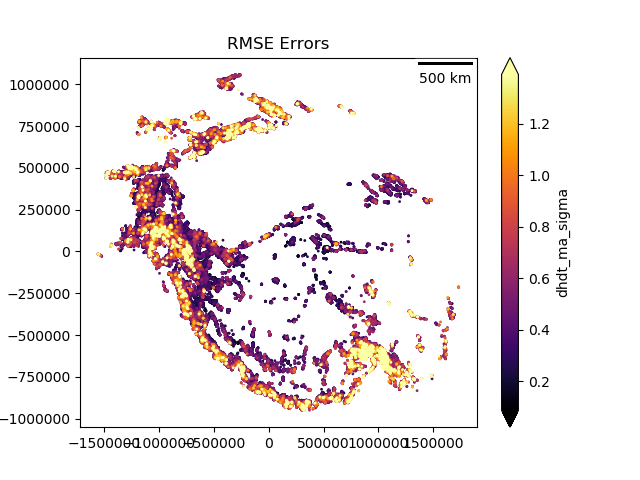

Text(0.5, 1.0, 'RMSE Errors')

In [24]:
fig,ax = plt.subplots()
plot_df = std_mean_df
z = 'dhdt_ma_sigma'
plot_df = plot_df.sort_values(by=z,ascending=True)
clim = np.percentile(plot_df[z],(2,98))
im = ax.scatter(plot_df['x'],plot_df['y'],c=plot_df['dhdt_ma_sigma'],cmap='inferno',vmax=clim[1],vmin=clim[0],s=1)
plt.colorbar(im,label='dhdt_ma_sigma',extend='both')
scalebar = ScaleBar(1.0)
ax.add_artist(scalebar)
ax.set_title('RMSE Errors')

In [26]:
dir_list = np.arange(0,181,15)
dir_list

array([  0,  15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165, 180])

In [27]:
len(dir_list)

13

<IPython.core.display.Javascript object>


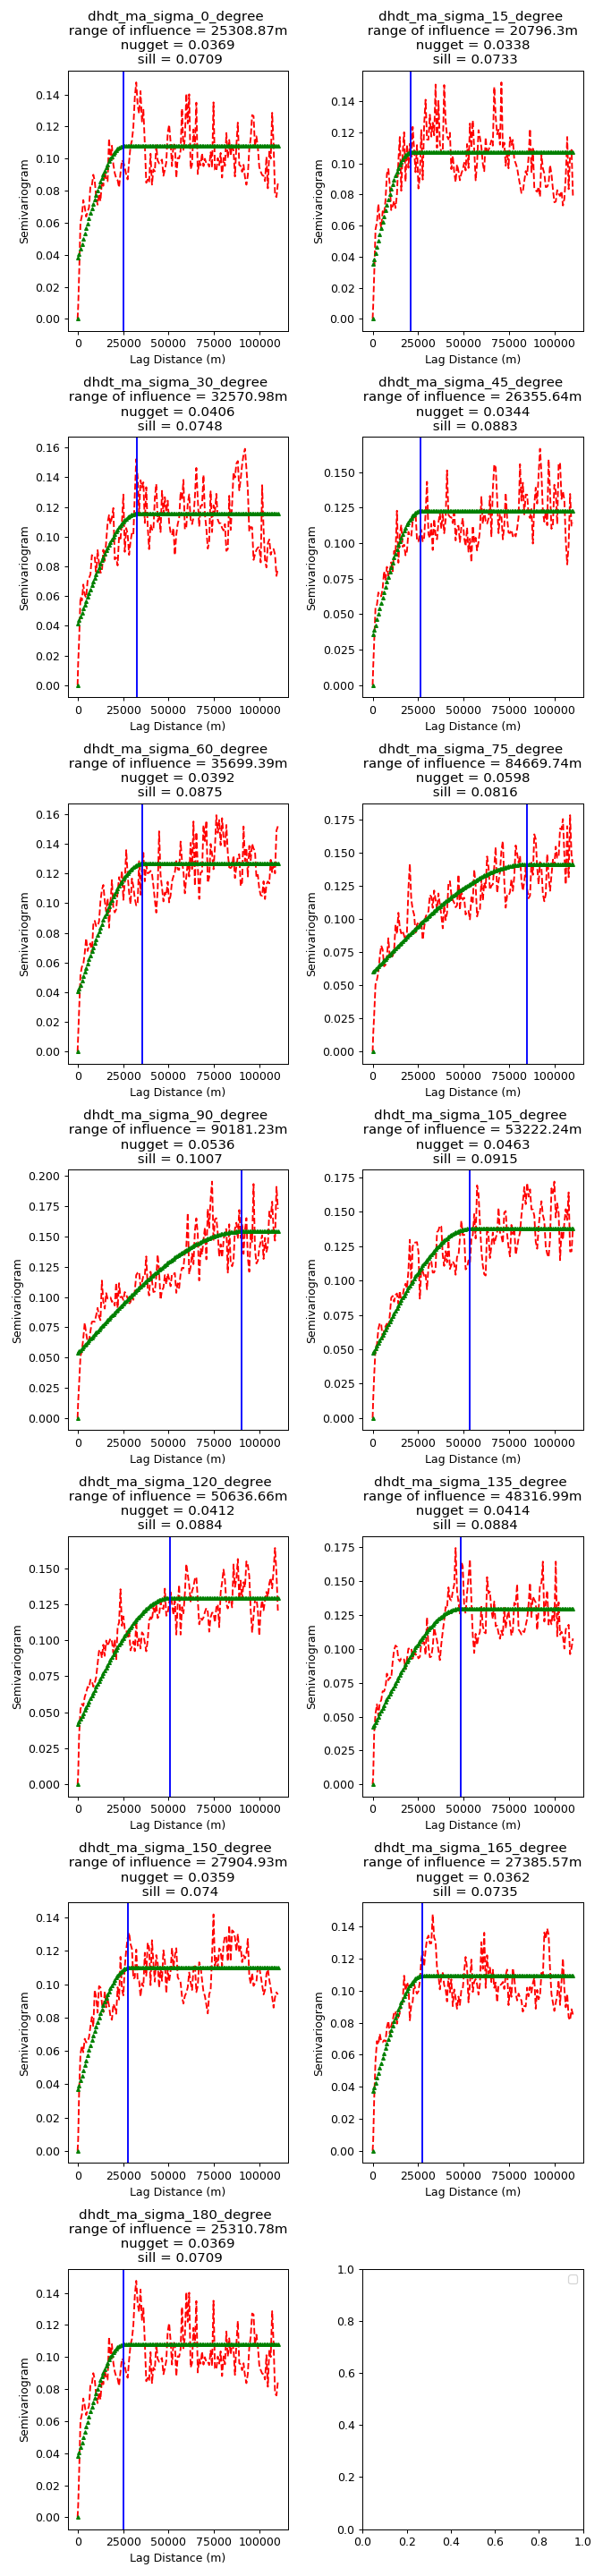

50


No handles with labels found to put in legend.


50


No handles with labels found to put in legend.


50


No handles with labels found to put in legend.


50


No handles with labels found to put in legend.


50


No handles with labels found to put in legend.


50


No handles with labels found to put in legend.


50


No handles with labels found to put in legend.


50


No handles with labels found to put in legend.


50


No handles with labels found to put in legend.


50


No handles with labels found to put in legend.


50


No handles with labels found to put in legend.


50


No handles with labels found to put in legend.


50


No handles with labels found to put in legend.


variance being modelled is 0.1302240818845965 


In [47]:
fig,ax = plt.subplots(7,2,figsize=(7.5,32))
axa = ax.ravel()
z = 'dhdt_ma_sigma'
nlags = 140
lag_dist = 786
model_df = std_mean_df
for i,direction in enumerate(dir_list):
    lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = variogram_wrapper(model_df,z,nlags,lag_dist,azi=dir_list[i],azi_tol=22.5,bandh=1.5*lag_dist,stand=0)
    out_z = z+'_{}_degree'.format(dir_list[i])
    if len(gamma_mbm) <2:
        simple_vario_plt(lag_mb,gamma_mb,out_z,ax=axa[i])
    else:
        vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,out_z,nugget,ax=axa[i],sill=sill)
    if i == len(dir_list):
        axa[i].axis('off')
plt.tight_layout()
print("variance being modelled is {} ".format(model_df[z].std()**2))
fig.savefig(os.path.join(figdir,'RMSE_dhdt.png'),dpi=300,pad_inches=0.01,bbox_inches='tight')
fig.savefig(os.path.join(figdir,'RMSE_dhdt.jpg'),dpi=300,pad_inches=0.01,bbox_inches='tight')

### for nmad_variable

<IPython.core.display.Javascript object>


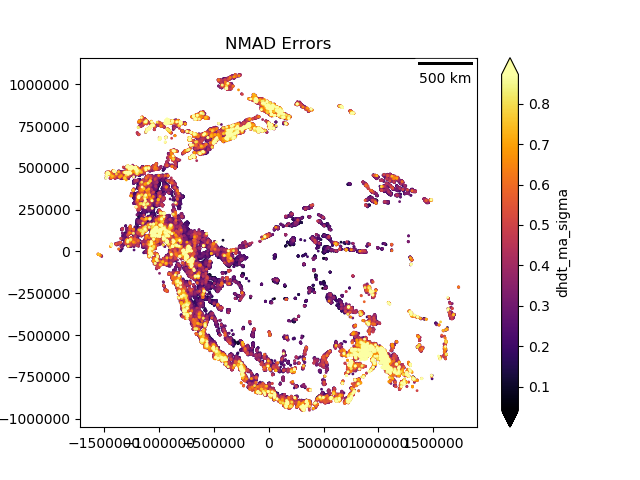

Text(0.5, 1.0, 'NMAD Errors')

In [40]:
fig,ax = plt.subplots()
plot_df = nmad_df
z = 'dhdt_ma_sigma'
plot_df = plot_df.sort_values(by=z,ascending=True)
clim = np.percentile(plot_df[z],(2,98))
im = ax.scatter(plot_df['x'],plot_df['y'],c=plot_df['dhdt_ma_sigma'],cmap='inferno',vmax=clim[1],vmin=clim[0],s=1)
plt.colorbar(im,label='dhdt_ma_sigma',extend='both')
scalebar = ScaleBar(1.0)
ax.add_artist(scalebar)
ax.set_title('NMAD Errors')

<IPython.core.display.Javascript object>


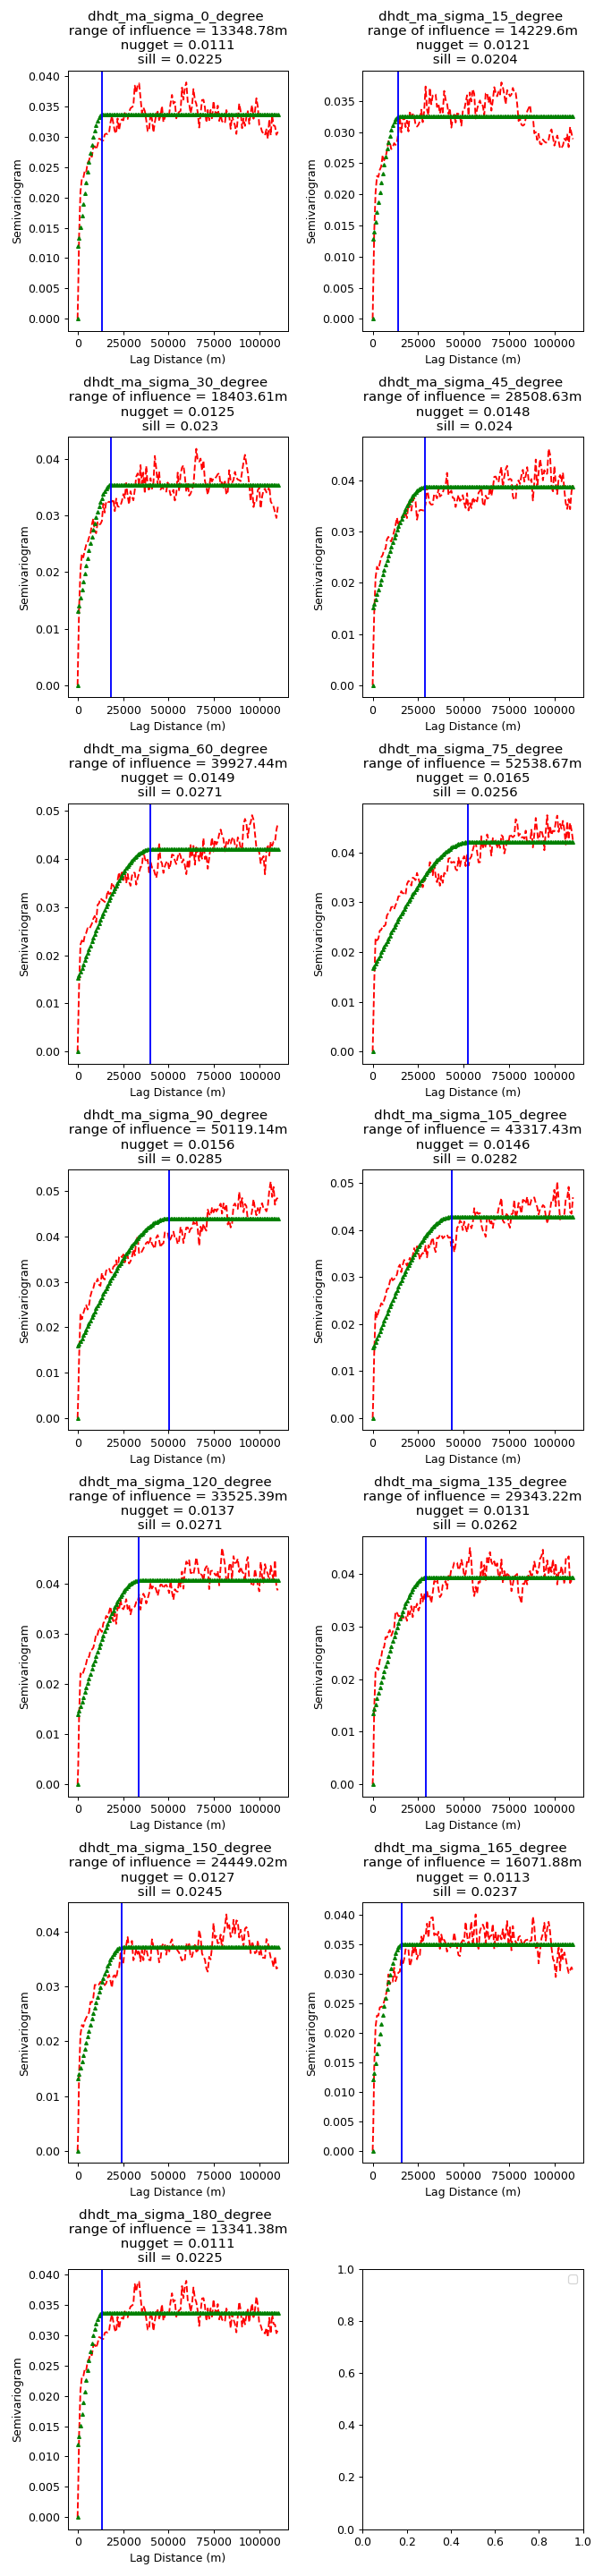

50


No handles with labels found to put in legend.


50


No handles with labels found to put in legend.


50


No handles with labels found to put in legend.


50


No handles with labels found to put in legend.


50


No handles with labels found to put in legend.


50


No handles with labels found to put in legend.


50


No handles with labels found to put in legend.


50


No handles with labels found to put in legend.


50


No handles with labels found to put in legend.


50


No handles with labels found to put in legend.


50


No handles with labels found to put in legend.


50


No handles with labels found to put in legend.


50


No handles with labels found to put in legend.


variance being modelled is 0.04588718889082878 


In [48]:
fig,ax = plt.subplots(7,2,figsize=(7.5,32))
axa = ax.ravel()
z = 'dhdt_ma_sigma'
nlags = 140
lag_dist = 786
model_df = nmad_df
for i,direction in enumerate(dir_list):
    lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = variogram_wrapper(model_df,z,nlags,lag_dist,azi=dir_list[i],azi_tol=22.5,bandh=1.5*lag_dist,stand=0)
    out_z = z+'_{}_degree'.format(dir_list[i])
    if len(gamma_mbm) <2:
        simple_vario_plt(lag_mb,gamma_mb,out_z,ax=axa[i])
    else:
        vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,out_z,nugget,ax=axa[i],sill=sill)
    if i == len(dir_list):
        axa[i].axis('off')
plt.tight_layout()
print("variance being modelled is {} ".format(model_df[z].std()**2))
fig.savefig(os.path.join(figdir,'NMAD_dhdt.png'),dpi=300,pad_inches=0.01,bbox_inches='tight')
fig.savefig(os.path.join(figdir,'NMAD_dhdt.jpg'),dpi=300,pad_inches=0.01,bbox_inches='tight')

#### Omnidirectional variogram

<IPython.core.display.Javascript object>


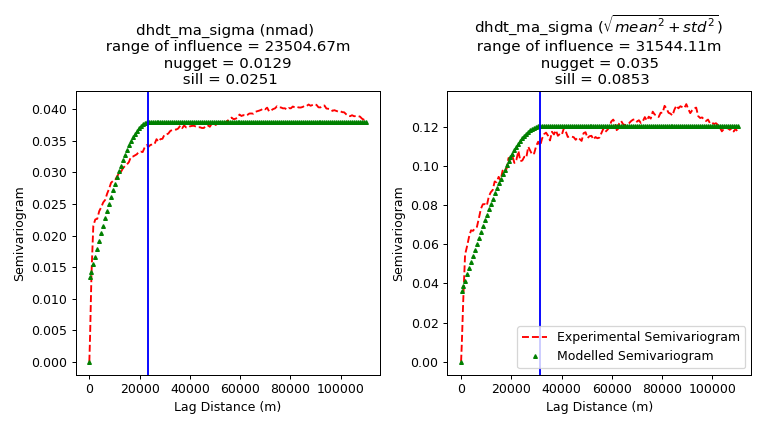

50


No handles with labels found to put in legend.


50


In [49]:
fig,axa = plt.subplots(1,2,figsize=(8.5,4.75))
z = 'dhdt_ma_sigma'
nlags = 140
#lag_dist = mean_near_neig
lag_dist = lag_dist
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = variogram_wrapper(nmad_df,z,nlags,lag_dist,stand=0)
if len(gamma_mbm) <2:
        simple_vario_plt(lag_mb,gamma_mb,z,ax=axa[0])
else:
    vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,'dhdt_ma_sigma (nmad)',nugget,ax=axa[0],sill=sill)
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = variogram_wrapper(std_mean_df,z,nlags,lag_dist,stand=0)
if len(gamma_mbm) <2:
    simple_vario_plt(lag_mb,gamma_mb,z,ax=axa[1])
else:
    vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,'dhdt_ma_sigma ($\sqrt{mean^2+std^2}$)',nugget,ax=axa[1],sill=sill)
plt.tight_layout()
fig.savefig(os.path.join(figdir,'Supplementary_Variogram_dhdt.png'),dpi=300,pad_inches=0.01,bbox_inches='tight')
fig.savefig(os.path.join(figdir,'Supplementary_Variogram_dhdt.jpg'),dpi=300,pad_inches=0.01,bbox_inches='tight')